# **CLIP**

In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def interpret_rollout(image, texts, model, device):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts, backward=True)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    all_layer_attentions = []
    for i, blk in enumerate(image_attn_blocks):
        cam = blk.attn_probs.detach()[0].unsqueeze(0)
        avg_heads = (cam.sum(dim=1) / cam.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=0)
        
    image_relevance = rollout[:, 0, 1:]
    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    all_layer_attentions = []
    for i, blk in enumerate(text_attn_blocks):
        cam = blk.attn_probs.detach()[0].unsqueeze(0)
        avg_heads = (cam.sum(dim=1) / cam.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    
    R_text = compute_rollout_attention(all_layer_attentions, start_layer=0)

    return image_relevance, R_text

In [4]:
def interpret_raw_attention(image, texts, model, device):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts, backward=True)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    h = len(image_attn_blocks)
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    blk = image_attn_blocks[-1]
    cam = blk.attn_probs.detach()
    cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1]).mean(1)
    
    R = cam
    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    blk = text_attn_blocks[-1]
    cam = blk.attn_probs.detach()
    cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1]).mean(1)

    return R[:,0,1:], cam

In [5]:
def interpret_ours(image, texts, model, device, num_layers=10):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts, backward=True)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    h = len(image_attn_blocks)
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i <=num_layers:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])
        
        Ih = torch.mean(torch.matmul(cam.transpose(-1,-2), grad).abs(), dim=(-1,-2)).unsqueeze(0)
        Ih = Ih/torch.sum(Ih)
        cam = torch.matmul(Ih.reshape(batch_size,1,h) ,cam.reshape(batch_size,h,-1)).reshape(batch_size,num_tokens,num_tokens)
        
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        R = R + torch.bmm(cam, R)

    steps=20
    total_gradients = torch.zeros(batch_size, h, num_tokens, num_tokens).cuda()
    for alpha in np.linspace(0, 1, steps):        
        # forward propagation
        data_scaled = images * alpha

        # backward propagation
        logits_per_image, logits_per_text = model(images, texts, backward=True)
        one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
        one_hot[np.arange(batch_size), index] = 1
        one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * logits_per_image)
        model.zero_grad()

        grad = torch.autograd.grad(one_hot, [image_attn_blocks[-1].attn_probs], retain_graph=True)[0].detach()
        grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])

        total_gradients += grad        

    W_state = (total_gradients / steps).clamp(min=0).mean(1)[:, 0, :].reshape(batch_size, 1, num_tokens)

    R = W_state * R  
    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    h =  text_attn_blocks[0].attn_probs.shape[0]
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i <=num_layers:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])
        
        Ih = torch.mean(torch.matmul(cam.transpose(-1,-2), grad).abs(), dim=(-1,-2)).unsqueeze(0)
        Ih = Ih/torch.sum(Ih)
        cam = torch.matmul(Ih.reshape(batch_size,1,h) ,cam.reshape(batch_size,h,-1)).reshape(batch_size,num_tokens,num_tokens)
        
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        R_text = R_text + torch.bmm(cam, R_text)

    steps=20
    total_gradients = torch.zeros(batch_size, h, num_tokens, num_tokens).cuda()
    for alpha in np.linspace(0, 1, steps):        
        # backward propagation
        logits_per_image, logits_per_text = model(images, texts, alpha, backward=True)
        one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
        one_hot[np.arange(batch_size), index] = 1
        one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * logits_per_image)
        model.zero_grad()

        grad = torch.autograd.grad(one_hot, [text_attn_blocks[-1].attn_probs], retain_graph=True)[0].detach()
        grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])

        total_gradients += grad        

    W_state = (total_gradients / steps).clamp(min=0).mean(1).reshape(batch_size, num_tokens, num_tokens)

    R_text = W_state * R_text
    

    return R[:,0,1:], R_text

In [6]:
def interpret_ours_c(image, texts, model, device, num_layers=8):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts, backward=True)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    h = len(image_attn_blocks)
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i <=num_layers:
          continue
        
        cam = blk.attn_probs.detach()
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1]).mean(1)
            
        z = blk.get_input().transpose(0,1)
        vproj = blk.get_vproj().transpose(0,1)
            
        order = torch.linalg.norm(vproj, dim=-1).squeeze()/torch.linalg.norm(z, dim=-1).squeeze()
        m = torch.diag_embed(order).cuda().unsqueeze(0)

        R = R + torch.bmm(torch.bmm(cam, m), R)

    steps=20
    total_gradients = torch.zeros(batch_size, h, num_tokens, num_tokens).cuda()
    for alpha in np.linspace(0, 1, steps):        
        # forward propagation
        data_scaled = images * alpha

        # backward propagation
        logits_per_image, logits_per_text = model(images, texts, backward=True)
        one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
        one_hot[np.arange(batch_size), index] = 1
        one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * logits_per_image)
        model.zero_grad()

        grad = torch.autograd.grad(one_hot, [image_attn_blocks[-1].attn_probs], retain_graph=True)[0].detach()
        grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])

        total_gradients += grad        

    W_state = (total_gradients / steps).clamp(min=0).mean(1)[:, 0, :].reshape(batch_size, 1, num_tokens)

    R = W_state * R
    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    h =  text_attn_blocks[0].attn_probs.shape[0]
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i <=num_layers:
          continue
        
        cam = blk.attn_probs.detach()
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1]).mean(1)
            
        z = blk.get_input().transpose(0,1)
        vproj = blk.get_vproj().transpose(0,1)
            
        order = torch.linalg.norm(vproj, dim=-1).squeeze()/torch.linalg.norm(z, dim=-1).squeeze()
        m = torch.diag_embed(order).cuda().unsqueeze(0)

        R_text = R_text + torch.bmm(torch.bmm(cam, m), R_text)

    steps=20
    total_gradients = torch.zeros(batch_size, h, num_tokens, num_tokens).cuda()
    for alpha in np.linspace(0, 1, steps):        
        # backward propagation
        logits_per_image, logits_per_text = model(images, texts, alpha, backward=True)
        one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
        one_hot[np.arange(batch_size), index] = 1
        one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * logits_per_image)
        model.zero_grad()

        grad = torch.autograd.grad(one_hot, [text_attn_blocks[-1].attn_probs], retain_graph=True)[0].detach()
        grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])

        total_gradients += grad        

    W_state = (total_gradients / steps).clamp(min=0).mean(1).reshape(batch_size, num_tokens, num_tokens)

    R_text = W_state * R_text

    return R[:,0,1:], R_text

In [7]:
 def interpret_cam_attn(image, texts, model, device):
        
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts, backward=True)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    blk = image_attn_blocks[-1]
    grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
    cam = blk.attn_probs.detach()
    cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
    grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])

    cam = cam[:, :, 0, 1:].reshape(batch_size, -1, 7,  7)
    grad = grad[:, :, 0, 1:].reshape(batch_size, -1,  7,  7)
    grad = grad.mean(dim=[-1, -2], keepdim=True)
    cam = (cam * grad).mean(1).clamp(min=0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    blk = text_attn_blocks[-1]
    grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
    cam_t = blk.attn_probs.detach()
    cam_t = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
    grad = grad.reshape(batch_size ,-1, grad.shape[-1], grad.shape[-1])

    cam_t = cam_t.reshape(batch_size, -1, 7,  7)
    grad = grad.reshape(batch_size, -1,  7,  7)
    grad = grad.mean(dim=[-1, -2], keepdim=True)
    cam_t = (cam_t * grad).mean(1).clamp(min=0)
    cam_t = (cam_t - cam_t.min()) / (cam_t.max() - cam_t.min())

    return cam, cam_t

In [8]:
def interpret(image, texts, model, device, num_layers=7, index=0):
    batch_size = texts.shape[0]
    logits_per_image, logits_per_text = model(image, texts, backward=True)
    probs = logits_per_image.softmax(dim=-1).detach()
    values, indices = probs[0].topk(1)
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i <=num_layers:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]
    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())
    h = len(text_attn_blocks)
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i <=num_layers:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
        

    return image_relevance, R_text

In [9]:
def show_image_relevance(image_relevance, image, name=None):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 1)

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs.imshow(vis);
    axs.axis('off');
    
    if name:
        fig.savefig(name, bbox_inches='tight', pad_inches=0)

In [10]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from captum.attr import visualization
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    text_tokens=_tokenizer.encode(text)
    text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
    visualization.visualize_text(vis_data_records)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("/root/datasets/models/pretrained_model/ViT-B-32.pt", device=device, jit=False)

/opt/conda/envs/torch1.10.1/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [12]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man in white shirt


/opt/conda/envs/torch1.10.1/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


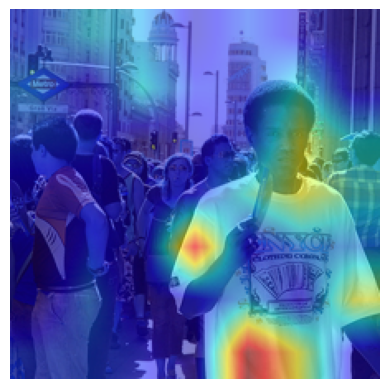

In [13]:
img = preprocess(Image.open("./case3.jpeg")).unsqueeze(0).to(device)
texts = ["a man in white shirt"]
text = clip.tokenize(texts).to(device)

R_image, R_text = interpret_ours_c(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img)
    plt.show()